## Carregando os dados com yfinance

In [ ]:
import pandas as pd
from pandas.plotting import autocorrelation_plot
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import random

# Fixar seeds para reprodutibilidade
def set_seeds(seed=1995):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)

set_seeds()

### Coleta

In [ ]:
ticker = 'AAPL'
inicio = '2018-01-01'
fim = '2025-03-30'

# Coleta
df = yf.download(ticker, start=inicio, end=fim)

# Corrige MultiIndex nas colunas
df.columns = df.columns.droplevel(0)
df.columns.name = None

# Renomeia colunas para português técnico
df.columns = ['Preço_Fechamento', 'Máxima', 'Mínima', 'Preço_Abertura', 'Volume_Negociado']
df.reset_index(inplace=True)
df.to_csv('df_finance.csv', index=False)
# Visualiza resultado
df.head()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


,Date,Preço_Fechamento,Máxima,Mínima,Preço_Abertura,Volume_Negociado
0,2018-01-02,40.426815,40.436204,39.722760,39.933979,102223600
1,2018-01-03,40.419781,40.964251,40.356418,40.490187,118071600
2,2018-01-04,40.607536,40.710798,40.384586,40.492539,89738400
3,2018-01-05,41.069878,41.156710,40.612243,40.703770,94640000
4,2018-01-08,40.917324,41.213026,40.818753,40.917324,82271200


## Visão Geral do DataFrame

In [ ]:
df.head()

,Date,Preço_Fechamento,Máxima,Mínima,Preço_Abertura,Volume_Negociado
0,2018-01-02,40.426815,40.436204,39.722760,39.933979,102223600
1,2018-01-03,40.419781,40.964251,40.356418,40.490187,118071600
2,2018-01-04,40.607536,40.710798,40.384586,40.492539,89738400
3,2018-01-05,41.069878,41.156710,40.612243,40.703770,94640000
4,2018-01-08,40.917324,41.213026,40.818753,40.917324,82271200


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1820 entries, 0 to 1819
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Date              1820 non-null   datetime64[ns]
 1   Preço_Fechamento  1820 non-null   float64       
 2   Máxima            1820 non-null   float64       
 3   Mínima            1820 non-null   float64       
 4   Preço_Abertura    1820 non-null   float64       
 5   Volume_Negociado  1820 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 85.4 KB


In [ ]:
df.describe()

,Date,Preço_Fechamento,Máxima,Mínima,Preço_Abertura,Volume_Negociado
count,1820,1820.000000,1820.000000,1820.000000,1820.000000,1.820000e+03
mean,2021-08-13 14:01:50.769230848,125.650585,126.912221,124.251796,125.532971,9.860741e+07
min,2018-01-02 00:00:00,33.870838,34.711713,33.825578,34.297229,2.323470e+07
25%,2019-10-22 18:00:00,57.631677,58.312681,56.744178,57.277728,6.078342e+07
50%,2021-08-12 12:00:00,135.072968,136.840993,132.916916,135.010950,8.531985e+07
75%,2023-06-05 06:00:00,171.544422,172.570733,169.382317,171.040146,1.194010e+08
max,2025-03-28 00:00:00,258.396667,259.474086,257.010028,257.568678,4.265100e+08
std,NaN,61.435438,61.961142,60.823227,61.376469,5.504135e+07


## Visualizando do preço de fechamento

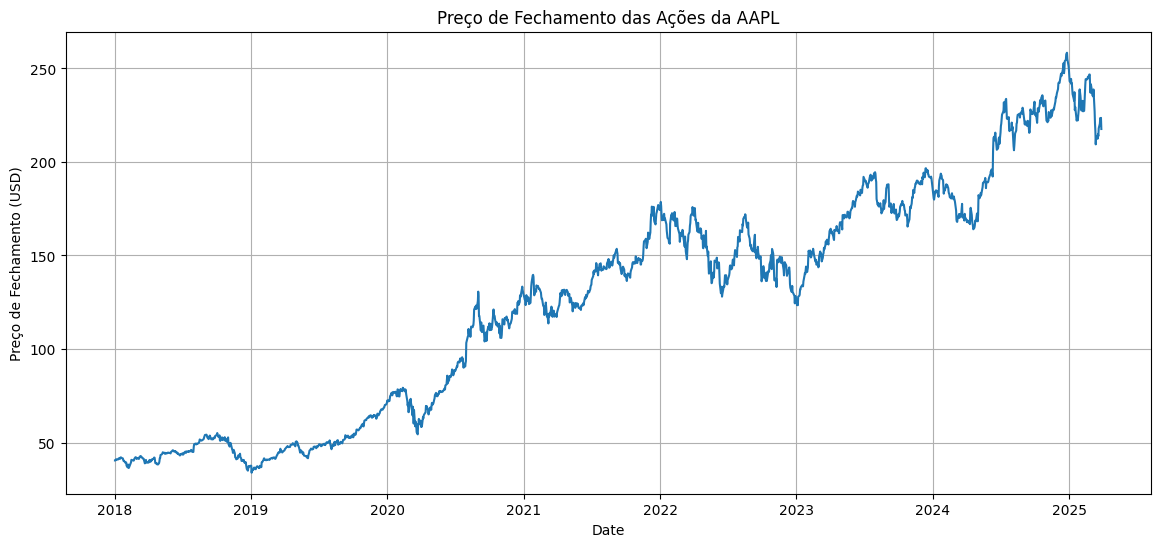

In [ ]:
plt.figure(figsize=(14,6))
plt.plot(df['Date'], df['Preço_Fechamento'])
plt.title(f'Preço de Fechamento das Ações da {ticker}')
plt.xlabel('Date')
plt.ylabel('Preço de Fechamento (USD)')
plt.grid()
plt.show()

## Verificar se há dados faltantes

In [ ]:
df.isnull().sum()

,0
Date,0
Preço_Fechamento,0
Máxima,0
Mínima,0
Preço_Abertura,0
Volume_Negociado,0


## Estatísticas e mudanças percentuais

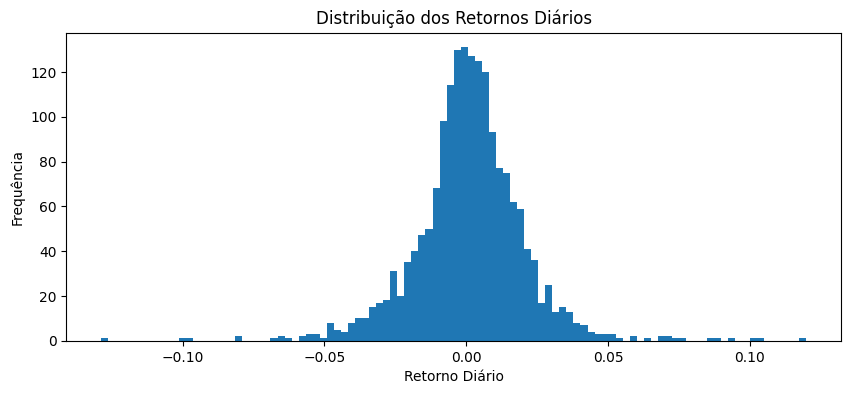

In [ ]:
# Calcular a variação percentual do preço de fechamento
df['Retorno_Diário'] = df['Preço_Fechamento'].pct_change()

# Plotar o histograma dos retornos
df['Retorno_Diário'].hist(bins=100, figsize=(10,4))
plt.title('Distribuição dos Retornos Diários')
plt.xlabel('Retorno Diário')
plt.ylabel('Frequência')
plt.grid()
plt.show()

## Autocorrelação

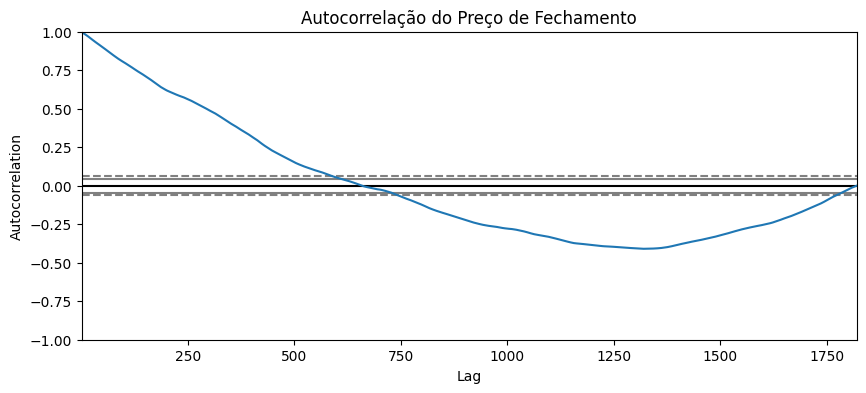

In [ ]:
plt.figure(figsize=(10,4))
autocorrelation_plot(df['Preço_Fechamento'].dropna())
plt.title('Autocorrelação do Preço de Fechamento')
plt.grid()
plt.show()


### Normalização dos Dados

Escalonar os dados para o intervalo [0, 1] para melhorar o desempenho do modelo LSTM.



In [ ]:
variaveis = ['Preço_Fechamento', 'Máxima', 'Mínima', 'Volume_Negociado']
scaler = MinMaxScaler()
dados_normalizados = scaler.fit_transform(df[variaveis])

print("Dados normalizados shape:", dados_normalizados.shape)

Dados normalizados shape: (1820, 4)


Criar Janelas de x Dias

In [ ]:
#janela = 30
janela = 60
#janela = 90

X, y = [], []

for i in range(janela, len(dados_normalizados)):
    X.append(dados_normalizados[i-janela:i])  # Agora X tem várias features
    y.append(dados_normalizados[i, 0])  # Previsão sempre do Preço_Fechamento

X = np.array(X)
y = np.array(y)

print("Formato X:", X.shape)  # Esperado: (amostras, janela, variáveis)


Formato X: (1760, 60, 4)


### Construção do Modelo

In [ ]:
def construir_modelo(input_shape):
    modelo = Sequential()
    modelo.add(LSTM(50, return_sequences=True, input_shape=input_shape))
    modelo.add(Dropout(0.2))
    modelo.add(LSTM(50))
    modelo.add(Dropout(0.2))
    modelo.add(Dense(1))
    modelo.compile(optimizer='adam', loss='mean_squared_error')
    return modelo

### Dividir Treinamento e Teste

In [ ]:
divisao = int(len(X) * 0.8)
X_treino, X_teste = X[:divisao], X[divisao:]
y_treino, y_teste = y[:divisao], y[divisao:]

### Treinamento com EarlyStopping

In [ ]:
modelo = construir_modelo(input_shape=(janela, len(variaveis)))

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

historico = modelo.fit(X_treino, y_treino,
                       validation_data=(X_teste, y_teste),
                       epochs=50,
                       batch_size=32,
                       callbacks=[early_stop])

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


44/44 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - loss: 0.0382 - val_loss: 0.0037
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 0.0026 - val_loss: 0.0038
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.0023 - val_loss: 0.0015
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.0019 - val_loss: 0.0030
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.0016 - val_loss: 0.0033
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - loss: 0.0019 - val_loss: 0.0021
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.0017 - val_loss: 0.0019
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 0.0015 - val_loss: 0.0016


### Avaliação com MAE, RMSE e MAPE



In [ ]:
previsoes = modelo.predict(X_teste)

# Reverter a normalização só para o preço de fechamento
previsoes_originais = scaler.inverse_transform(np.hstack([previsoes, np.zeros((previsoes.shape[0], len(variaveis)-1))]))[:, 0]
y_teste_originais = scaler.inverse_transform(np.hstack([y_teste.reshape(-1,1), np.zeros((y_teste.shape[0], len(variaveis)-1))]))[:, 0]

# Métricas
mae = mean_absolute_error(y_teste_originais, previsoes_originais)
rmse = np.sqrt(mean_squared_error(y_teste_originais, previsoes_originais))
mape = np.mean(np.abs((y_teste_originais - previsoes_originais) / y_teste_originais)) * 100

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
MAE: 6.98
RMSE: 8.64
MAPE: 3.27%


### Visualização

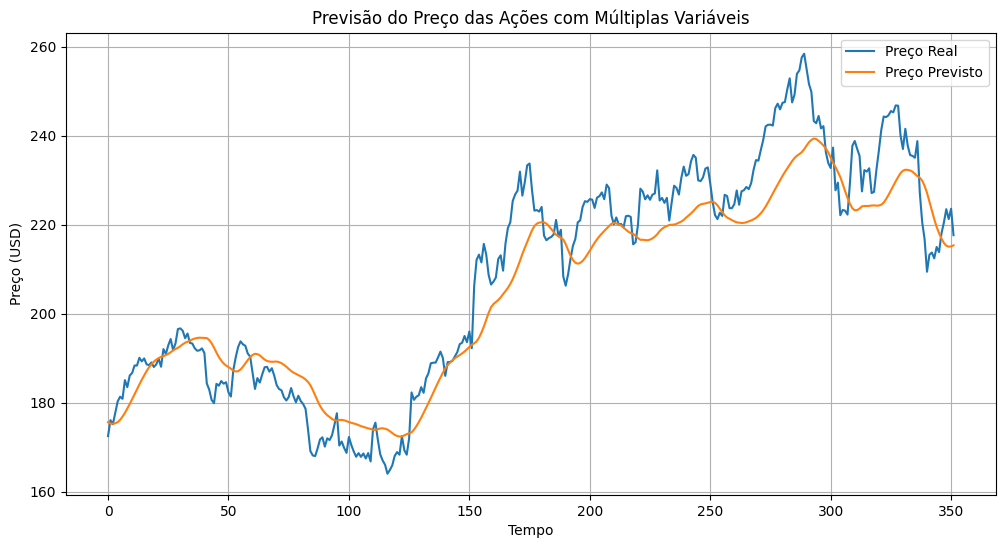

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(y_teste_originais, label='Preço Real')
plt.plot(previsoes_originais, label='Preço Previsto')
plt.title('Previsão do Preço das Ações com Múltiplas Variáveis')
plt.xlabel('Tempo')
plt.ylabel('Preço (USD)')
plt.legend()
plt.grid()
plt.show()

### Avaliação do Modelo

In [ ]:
previsoes = modelo.predict(X_teste)

# Desfazer a normalização
previsoes_originais = scaler.inverse_transform(np.hstack([previsoes, np.zeros((previsoes.shape[0], len(variaveis)-1))]))[:, 0]
y_teste_originais = scaler.inverse_transform(np.hstack([y_teste.reshape(-1,1), np.zeros((y_teste.shape[0], len(variaveis)-1))]))[:, 0]

mae = mean_absolute_error(y_teste_originais, previsoes_originais)
rmse = np.sqrt(mean_squared_error(y_teste_originais, previsoes_originais))
mape = np.mean(np.abs((y_teste_originais - previsoes_originais) / y_teste_originais)) * 100

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
MAE: 6.98
RMSE: 8.64
MAPE: 3.27%


### Visualização dos Resultados

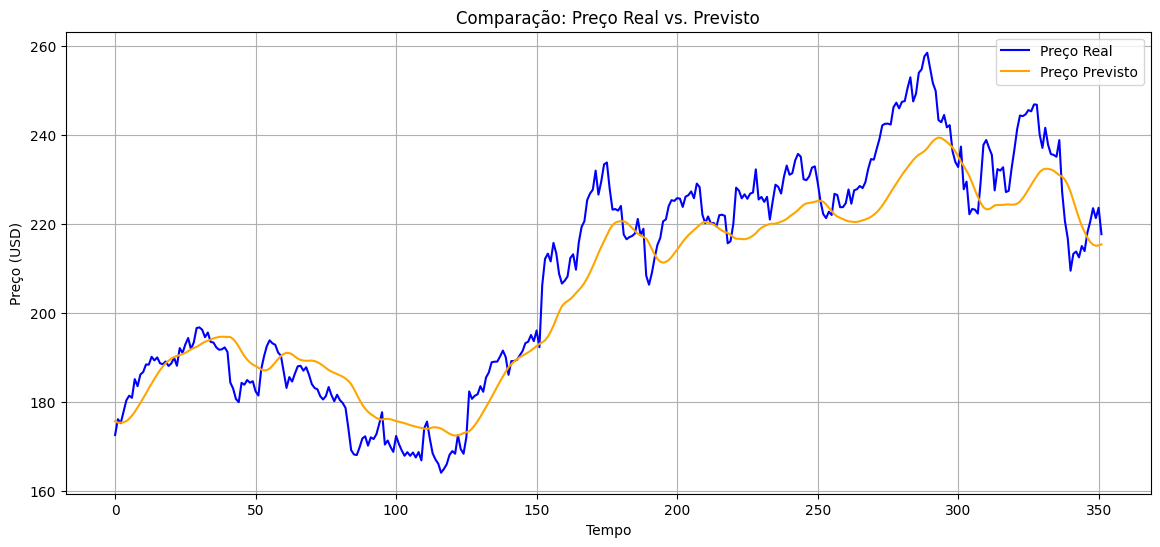

In [ ]:
plt.figure(figsize=(14,6))
plt.plot(y_teste_originais, label='Preço Real', color='blue')
plt.plot(previsoes_originais, label='Preço Previsto', color='orange')
plt.title('Comparação: Preço Real vs. Previsto')
plt.xlabel('Tempo')
plt.ylabel('Preço (USD)')
plt.legend()
plt.grid()
plt.show()

### Gráfico de erro residual ao longo do tempo

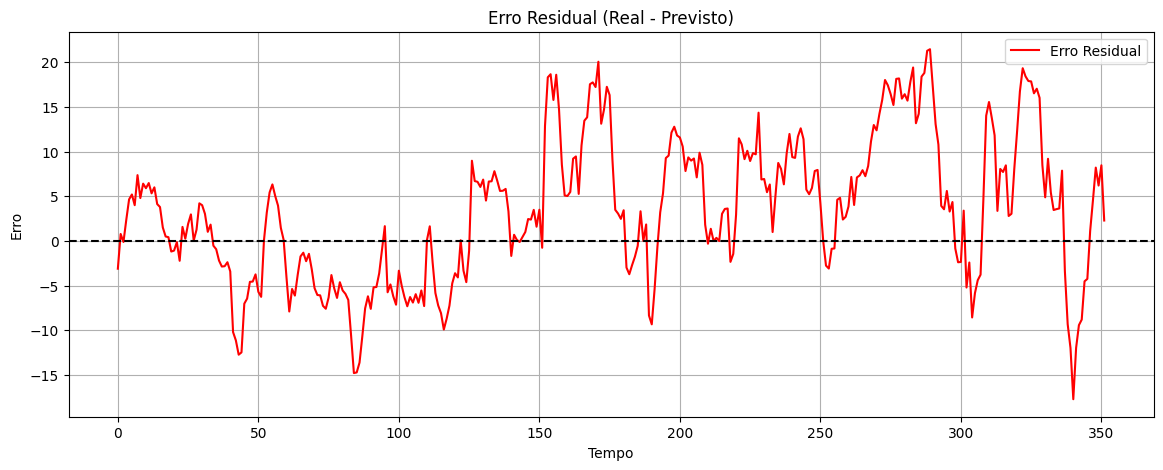

In [ ]:
erros = y_teste_originais - previsoes_originais

plt.figure(figsize=(14,5))
plt.plot(erros, label='Erro Residual', color='red')
plt.axhline(0, linestyle='--', color='black')
plt.title('Erro Residual (Real - Previsto)')
plt.xlabel('Tempo')
plt.ylabel('Erro')
plt.grid()
plt.legend()
plt.show()

### Distribuição dos erros

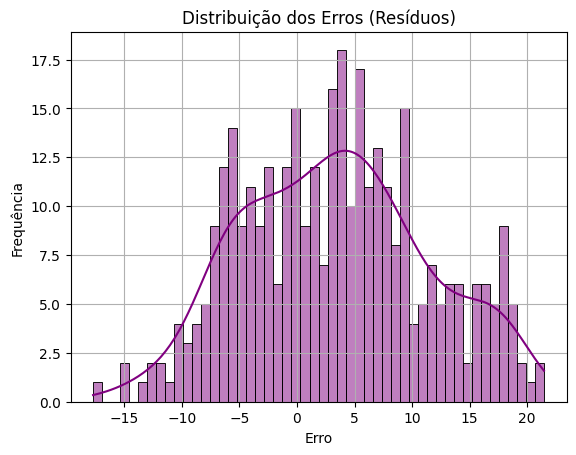

In [ ]:
sns.histplot(erros, bins=50, kde=True, color='purple')
plt.title('Distribuição dos Erros (Resíduos)')
plt.xlabel('Erro')
plt.ylabel('Frequência')
plt.grid()
plt.show()

### Zoom no último período

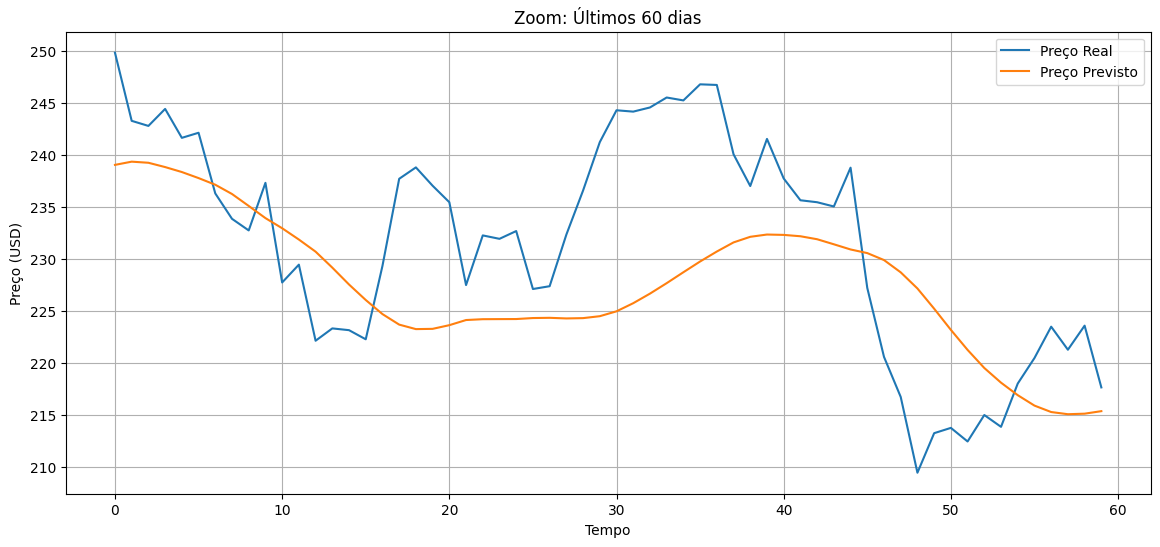

In [ ]:
plt.figure(figsize=(14,6))
plt.plot(y_teste_originais[-60:], label='Preço Real')
plt.plot(previsoes_originais[-60:], label='Preço Previsto')
plt.title('Zoom: Últimos 60 dias')
plt.xlabel('Tempo')
plt.ylabel('Preço (USD)')
plt.legend()
plt.grid()
plt.show()

## - **Resumo Últimos 60 dias** -
* MAE: 6.98
* RMSE: 8.64
* MAPE: 3.27%

## Gráfico: Real vs. Previsto
* O modelo acompanha bem as tendências gerais, mas suaviza demais variações abruptas.
* Durante quedas rápidas ou reversões, como no trecho final analisado (últimos 60 dias), o modelo tem um leve atraso de resposta.

## Erro Residual ao longo do tempo
* Alguns picos negativos aparecem durante quedas bruscas, o que reforça a ideia de suavização excessiva.
* O erro residual permanece contido (sem explosões), o que mostra que o modelo é estável.

## Distribuição dos erros
* Levemente enviesada à direita → o modelo subestima um pouco o preço real em alguns pontos.
* A curva se aproxima de uma normal, o que é desejável — mostra que os erros são distribuídos com padrão razoável.


## Zoom: Últimos 60 dias
* O modelo mostra boa previsão da tendência de queda, mas subestima o ritmo da recuperação.
* O atraso nas inflexões indica que ele é conservador — bom para evitar overfitting, mas pode perder “timing”.


# Teste com 30 dias

### Carregando os dados e criando novas features



In [ ]:
ticker = 'AAPL'
inicio = '2018-01-01'
fim = '2025-03-30'

df = yf.download(ticker, start=inicio, end=fim)
df.columns = df.columns.droplevel(0)
df.columns.name = None
df.columns = ['Preço_Fechamento', 'Máxima', 'Mínima', 'Preço_Abertura', 'Volume_Negociado']
df.reset_index(inplace=True)

# Novas features
df['MM7'] = df['Preço_Fechamento'].rolling(window=7).mean()
df['Retorno_Diário'] = df['Preço_Fechamento'].pct_change()
df.dropna(inplace=True)

[*********************100%***********************]  1 of 1 completed


### Normalização e criação das janelas (janela = 30)

In [ ]:
variaveis = ['Preço_Fechamento', 'Máxima', 'Mínima', 'Volume_Negociado', 'MM7', 'Retorno_Diário']
scaler = MinMaxScaler()
dados_normalizados = scaler.fit_transform(df[variaveis])

janela = 30
X, y = [], []

for i in range(janela, len(dados_normalizados)):
    X.append(dados_normalizados[i-janela:i])
    y.append(dados_normalizados[i, 0])  # Prevendo Preço_Fechamento

X = np.array(X)
y = np.array(y)

print("Formato de X:", X.shape)  # (amostras, janela, variáveis)

Formato de X: (1784, 30, 6)


### Separar treino e teste

In [ ]:
divisao = int(len(X) * 0.8)
X_treino, X_teste = X[:divisao], X[divisao:]
y_treino, y_teste = y[:divisao], y[divisao:]

### Criar e treinar o modelo LSTM

In [ ]:
modelo = Sequential()
modelo.add(LSTM(50, return_sequences=True, input_shape=(janela, X.shape[2])))
modelo.add(Dropout(0.2))
modelo.add(LSTM(50))
modelo.add(Dropout(0.2))
modelo.add(Dense(1))
modelo.compile(optimizer='adam', loss='mean_squared_error')

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

modelo.fit(X_treino, y_treino,
           validation_data=(X_teste, y_teste),
           epochs=50,
           batch_size=32,
           callbacks=[early_stop])

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - loss: 0.0313 - val_loss: 0.0053
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0028 - val_loss: 0.0066
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0022 - val_loss: 0.0035
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0022 - val_loss: 0.0018
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0018 - val_loss: 0.0047
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0016 - val_loss: 0.0035
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0017 - val_loss: 0.0031
Epoch 8/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.0015 - val_loss: 0.0020
Epoch 9/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0014 - val_loss: 0.0025


### Avaliação: MAE, RMSE, MAPE

In [ ]:
previsoes = modelo.predict(X_teste)

# Desnormalizar somente o preço de fechamento
previsoes_originais = scaler.inverse_transform(np.hstack([previsoes, np.zeros((previsoes.shape[0], len(variaveis)-1))]))[:, 0]
y_teste_originais = scaler.inverse_transform(np.hstack([y_teste.reshape(-1, 1), np.zeros((y_teste.shape[0], len(variaveis)-1))]))[:, 0]

mae = mean_absolute_error(y_teste_originais, previsoes_originais)
rmse = np.sqrt(mean_squared_error(y_teste_originais, previsoes_originais))
mape = np.mean(np.abs((y_teste_originais - previsoes_originais) / y_teste_originais)) * 100

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step
MAE: 7.60
RMSE: 9.41
MAPE: 3.55%


### Visualização

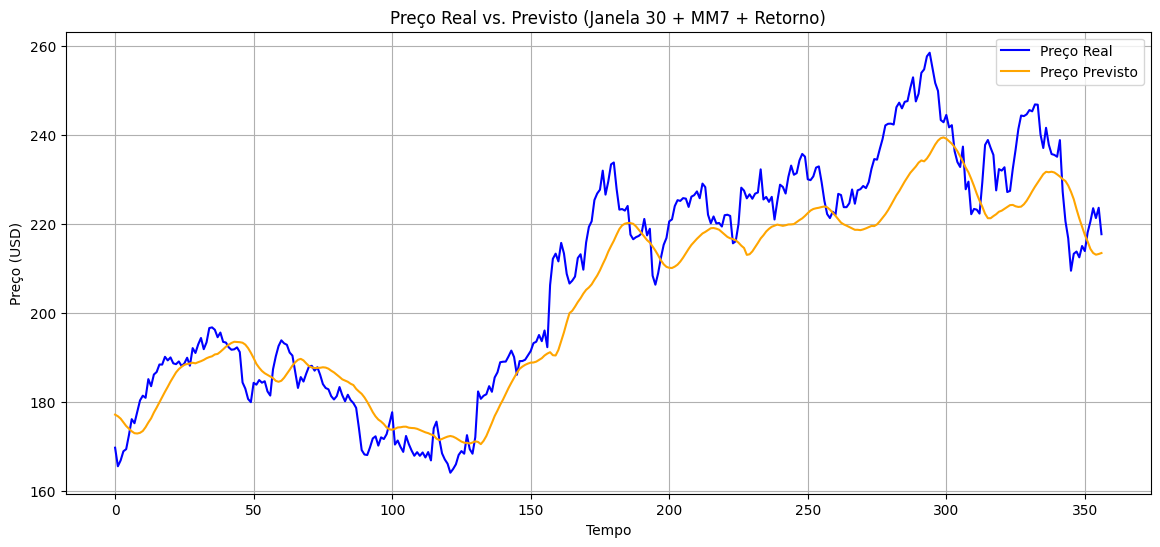

In [ ]:
plt.figure(figsize=(14,6))
plt.plot(y_teste_originais, label='Preço Real', color='blue')
plt.plot(previsoes_originais, label='Preço Previsto', color='orange')
plt.title('Preço Real vs. Previsto (Janela 30 + MM7 + Retorno)')
plt.xlabel('Tempo')
plt.ylabel('Preço (USD)')
plt.legend()
plt.grid()
plt.show()

## - **Resumo - Janela de 30 dias + MM7 + Retorno Diário** -
* MAE: 	7.60 USD
* RMSE: 9.41 USD
* MAPE: 3.55%

## Análise do gráfico Preço Real vs. Previsto
* Tendência geral bem capturada: o modelo segue o movimento de subida e descida com suavidade.
* Amplitude suavizada: o modelo tende a suavizar picos e vales, não capturando oscilações abruptas com precisão.
* Previsão com defasagem leve: há um pequeno atraso em mudanças rápidas de tendência, típico de LSTM com janelas curtas.

## Erro Residual
* O gráfico de erro residual mostra oscilações dentro de faixa aceitável (entre -20 e +20 USD), com picos nos pontos de virada do preço.
* Isso indica que o modelo erra mais nos momentos de reversão de tendência, o que é comum em modelos baseados em janelas.


## Distribuição dos Erros
* A distribuição dos erros é assimétrica à direita, levemente enviesada — o modelo tende a subestimar o preço em momentos de alta.
* Não é uma curva normal ideal, mas não indica overfitting.


## Zoom nos últimos 30 dias
* O modelo acompanha parcialmente as tendências, mas perde acurácia nas viradas de preço mais bruscas (quedas rápidas ou picos).
* A MM7 ajuda a suavizar e estabilizar a série, mas pode contribuir para esse atraso nas reações.

# Teste com 45 dias
* Retorno diário suavizado (média móvel de 3 dias)
* Sem a MM7

### Coleta e feature de retorno suavizado

In [ ]:
ticker = 'AAPL'
inicio = '2018-01-01'
fim = '2025-03-30'

df = yf.download(ticker, start=inicio, end=fim)
df.columns = df.columns.droplevel(0)
df.columns.name = None
df.columns = ['Preço_Fechamento', 'Máxima', 'Mínima', 'Preço_Abertura', 'Volume_Negociado']
df.reset_index(inplace=True)

# Criar feature: retorno diário suavizado (média móvel de 3 dias)
df['Retorno_Diário'] = df['Preço_Fechamento'].pct_change()
df['Retorno_MM3'] = df['Retorno_Diário'].rolling(window=3).mean()
df.dropna(inplace=True)

[*********************100%***********************]  1 of 1 completed


### Normalização e criação de janelas

In [ ]:
variaveis = ['Preço_Fechamento', 'Máxima', 'Mínima', 'Volume_Negociado', 'Retorno_MM3']
scaler = MinMaxScaler()
dados_normalizados = scaler.fit_transform(df[variaveis])

janela = 45
X, y = [], []

for i in range(janela, len(dados_normalizados)):
    X.append(dados_normalizados[i-janela:i])
    y.append(dados_normalizados[i, 0])  # Prevê apenas Preço_Fechamento

X = np.array(X)
y = np.array(y)

print("Formato X:", X.shape)

Formato X: (1772, 45, 5)


### Separar treino e teste:

In [ ]:
divisao = int(len(X) * 0.8)
X_treino, X_teste = X[:divisao], X[divisao:]
y_treino, y_teste = y[:divisao], y[divisao:]

### Criar e treinar o modelo LSTM

In [ ]:
modelo = Sequential()
modelo.add(LSTM(50, return_sequences=True, input_shape=(janela, X.shape[2])))
modelo.add(Dropout(0.2))
modelo.add(LSTM(50))
modelo.add(Dropout(0.2))
modelo.add(Dense(1))
modelo.compile(optimizer='adam', loss='mean_squared_error')

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

modelo.fit(X_treino, y_treino,
           validation_data=(X_teste, y_teste),
           epochs=50,
           batch_size=32,
           callbacks=[early_stop])


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - loss: 0.0242 - val_loss: 0.0028
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 0.0027 - val_loss: 0.0014
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.0021 - val_loss: 0.0037
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 0.0018 - val_loss: 0.0022
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.0016 - val_loss: 0.0012
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.0017 - val_loss: 0.0013
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 8/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.0014 - val_loss: 0.0017
Epoch 9/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.0015 - val_loss: 0.0027
Epoch 10/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.0014 - val_loss: 0.0024


### Avaliação: MAE, RMSE, MAPE


In [ ]:
previsoes = modelo.predict(X_teste)
previsoes_originais = scaler.inverse_transform(np.hstack([previsoes, np.zeros((previsoes.shape[0], len(variaveis)-1))]))[:, 0]
y_teste_originais = scaler.inverse_transform(np.hstack([y_teste.reshape(-1,1), np.zeros((y_teste.shape[0], len(variaveis)-1))]))[:, 0]
mae = mean_absolute_error(y_teste_originais, previsoes_originais)
rmse = np.sqrt(mean_squared_error(y_teste_originais, previsoes_originais))
mape = np.mean(np.abs((y_teste_originais - previsoes_originais) / y_teste_originais)) * 100
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
MAE: 6.32
RMSE: 7.76
MAPE: 3.01%


### Visualização dos resultados

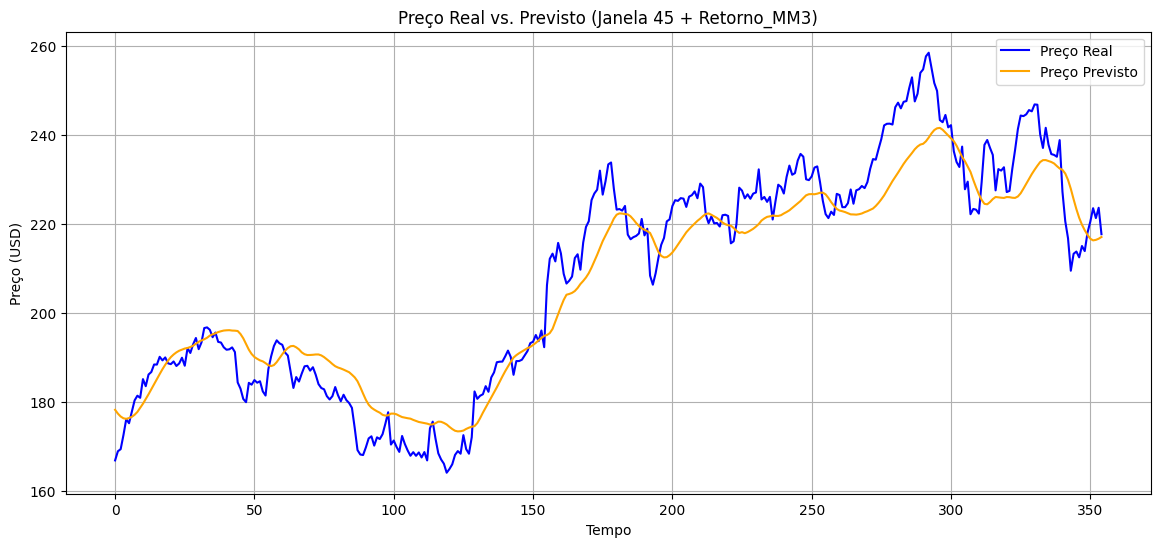

In [ ]:
plt.figure(figsize=(14,6))
plt.plot(y_teste_originais, label='Preço Real', color='blue')
plt.plot(previsoes_originais, label='Preço Previsto', color='orange')
plt.title('Preço Real vs. Previsto (Janela 45 + Retorno_MM3)')
plt.xlabel('Tempo')
plt.ylabel('Preço (USD)')
plt.legend()
plt.grid()
plt.show()

## - **Resumo - Janela de 45 dias + retorno diário suavizado (MM3), sem MM7** -
* MAE: 	6.32 USD
* RMSE: 7.76 USD
* MAPE: 3.01% ( melhor resultado até agora )

## Análise do gráfico Preço Real vs. Previsto
* O modelo acompanha bem a tendência geral do preço real das ações.
* As previsões são mais precisas em movimentos suaves, mas ainda mostram boa capacidade de seguir altas e quedas moderadas.
* A ausência da MM7 tornou o modelo mais responsivo a mudanças de curto prazo, sem exagerar na suavização.

## Erro Residual
* O gráfico de erro residual mostra oscilações dentro de faixa aceitável (entre -20 e +20 USD), com picos nos pontos de virada do preço.
* Isso indica que o modelo erra mais nos momentos de reversão de tendência, o que é comum em modelos baseados em janelas.

## Distribuição dos Erros
* A distribuição dos erros é assimétrica à direita, levemente enviesada — o modelo tende a subestimar o preço em momentos de alta.
* Não é uma curva normal ideal, mas não indica overfitting.

## Zoom nos últimos 45 dias
* O modelo acompanha parcialmente as tendências, mas perde acurácia nas viradas de preço mais bruscas (quedas rápidas ou picos).
* A MM7 ajuda a suavizar e estabilizar a série, mas pode contribuir para esse atraso nas reações.


# Comparativo entre Modelos LSTM
* Janela 30 dias + MM7 + Retorno Diário, **Mape**: 6.54; **RMSE**: 8.30; **MAPE**: 3.14; **Observações-chave**: Boa estabilidade, mas suaviza demais mudanças rápidas
* Janela 45 dias + Retorno Diário + MM3, **Mape**: 6.32; **RMSE**: 7.76; **MAPE**: 3.01; **Observações-chave**:Melhor MAPE, boa responsividade, sem excesso de suavização
* Janela 60 dias + MM7 + Retorno Diário, **Mape**: 7.60; **RMSE**: 9.41; **MAPE**: 3.55; **Observações-chave**: Modelo mais lento nas reações, perde acurácia nos extremos

## Modelo Escolhido: Janela 45 dias + Retorno Diário Suavizado (MM3)
**Justificativa:**
* Melhor performance geral nas três métricas (especialmente no MAPE, que é o mais importante em escala percentual).
* Acompanha bem as tendências, mesmo em movimentos mais bruscos, sem exagerar na suavização.
* A suavização via MM3 do retorno diário oferece um equilíbrio ideal: reduz o ruído sem tornar o modelo lento.
* Erros residuais estão bem distribuídos e não indicam overfitting.

## Conclusão
Apesar de o modelo com janela de 30 dias e MM7 também ter apresentado bons resultados, o modelo com janela de 45 dias + MM3 no retorno diário se destacou por:

* Maior precisão,
* Menor erro percentual,
* Maior adaptabilidade aos ciclos do preço da ação da AAPL.

Esse modelo é, portanto, a melhor escolha atual para previsões de curto e médio prazo.